In [1]:
!pip install fairlearn
import pandas as pd
import numpy as np
from random import sample
from sklearn.metrics import recall_score
from sklearn.metrics import plot_confusion_matrix
from fairlearn.metrics import demographic_parity_ratio
from sklearn.metrics import confusion_matrix
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from fairlearn.metrics import equalized_odds_difference
from fairlearn.metrics import demographic_parity_difference
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import f_oneway
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-white')
import seaborn as sns

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from plotly import tools

In [2]:
df=pd.read_csv("C:/Users/danie/OneDrive/Desktop/diabetic_data.csv")
df.head(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [3]:
#visualizzo le features di questo dataset
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [4]:
df["discharge_disposition_id"].unique()

array([25,  1,  3,  6,  2,  5, 11,  7, 10,  4, 14, 18,  8, 13, 12, 16, 17,
       22, 23,  9, 20, 15, 24, 28, 19, 27], dtype=int64)

Il dataset contiene più di una occorrenza per ciascuna visita effettuata su un paziente ricoverato. Considero quindi solo la prima visita per ciascun paziente come primary admission e determino basandomi su questo, se il paziente viene poi riammesso o meno entro 30 giorni. Questo lo faccio per tenere un certo grado di indipendenza tra le varie tuple.

In [5]:
df=df.drop_duplicates(subset=['patient_nbr'],keep='first')

Rimuovo anche quei risultati che si sono conclusi o con la morte del paziente oppure con la sua dimissione presso un ospizio. Questo viene fatto per evitare l'insorgenza di bias durante l'analisi. 

## Null Values

In [6]:
for i in df.columns:
    print(i, df[df[i] == '?'].shape[0])

encounter_id 0
patient_nbr 0
race 1948
gender 0
age 0
weight 68665
admission_type_id 0
discharge_disposition_id 0
admission_source_id 0
time_in_hospital 0
payer_code 31043
medical_specialty 34477
num_lab_procedures 0
num_procedures 0
num_medications 0
number_outpatient 0
number_emergency 0
number_inpatient 0
diag_1 11
diag_2 294
diag_3 1225
number_diagnoses 0
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
pioglitazone 0
rosiglitazone 0
acarbose 0
miglitol 0
troglitazone 0
tolazamide 0
examide 0
citoglipton 0
insulin 0
glyburide-metformin 0
glipizide-metformin 0
glimepiride-pioglitazone 0
metformin-rosiglitazone 0
metformin-pioglitazone 0
change 0
diabetesMed 0
readmitted 0


Weights had 97% of valus null. So we drop the column

Siccome la quantità di race e delle diagnosi è bassa, droppiamo queste righe

In [7]:
df = df[df["race"] != '?']
df = df[df["diag_1"] != '?']
df = df[df["diag_2"] != '?']
df = df[df["diag_3"] != '?']

Per payer code e medical spaciality, si possono seguire due vie. La prima è quella di rimuovere le colonne, la seconda è quella di sostituire il valore con la moda. Oppure possiamo creare un modello e metterlo dentro.

In [8]:
df1=df.drop(['payer_code','medical_specialty','weight'], axis=1)

In [9]:
df1.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,35754,82637451,Caucasian,Male,[50-60),2,1,2,3,31,...,No,Steady,No,No,No,No,No,No,Yes,>30


Questo conclude la parte di cleaning. Passiamo ora ad analizzare l'outcome. 

In [10]:
df1['readmitted'].value_counts()

NO     40729
>30    21539
<30     6090
Name: readmitted, dtype: int64

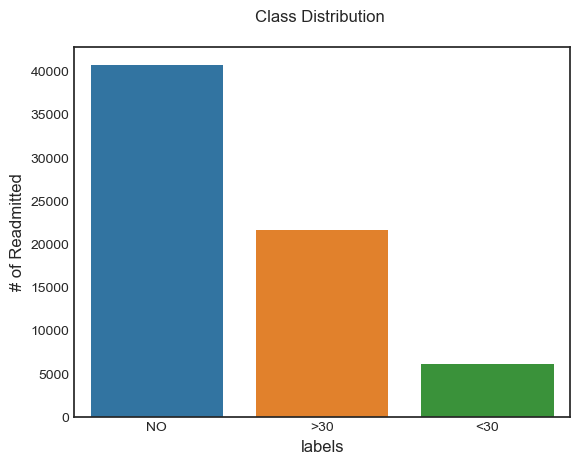

In [11]:
ax = sns.barplot(x=df1['readmitted'].value_counts().index,   y=df1['readmitted'].value_counts())
plt.xlabel('labels', size = 12)
plt.ylabel('# of Readmitted', size = 12)
plt.title('Class Distribution \n', size = 12)
plt.show()

Come vediamo dall'analisi, la maggior parte degli outcome consistono di pazienti che non hanno un record di riammissione all'interno dell'ospedale, circa 22000 pazienti sono stati riammessi dopo un periodo superiore ai 30 giorni, e poco più di 5000 sono stati riammessi sotto i 30 giorni. Una cosa interessante sarebbe capire se per esempio ci sia delle discriminazione verso la razza, ossia se magari quelli ad essere stati riammessi siano piu neri che bianchi, oppure se ci sia una discriminazione verso il sesso.

Per chiarezza, andiamo a capire solo se il paziente è stato riammesso oppure no, trasformando quindi l'outcome in una variabile binaria: 1 se non è stato riammesso, 0 se lo è stato

In [12]:
df1['readmitted'].replace(['>30','<30','NO'],[0,0,1],inplace=True)
df1.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,Up,No,No,No,No,No,Ch,Yes,0
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,No,Yes,1
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,Up,No,No,No,No,No,Ch,Yes,1
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,Steady,No,No,No,No,No,Ch,Yes,1
5,35754,82637451,Caucasian,Male,[50-60),2,1,2,3,31,...,No,Steady,No,No,No,No,No,No,Yes,0


In [13]:
#df1['readmitted'].unique()

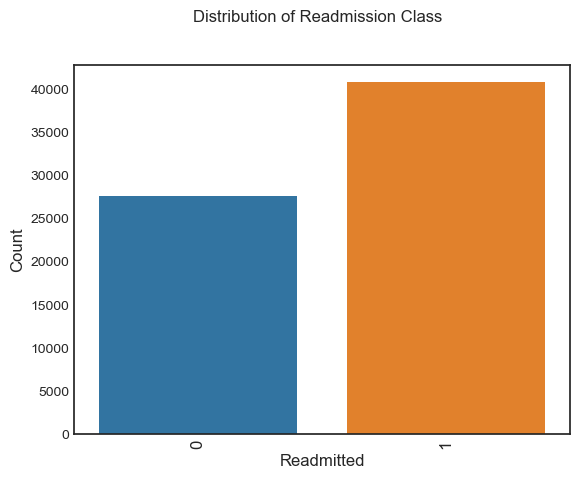

In [14]:
ax = sns.countplot(x='readmitted',   data= df1)
plt.xlabel('Readmitted', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('Distribution of Readmission Class  \n\n', size = 12)
plt.show()

We see now the race

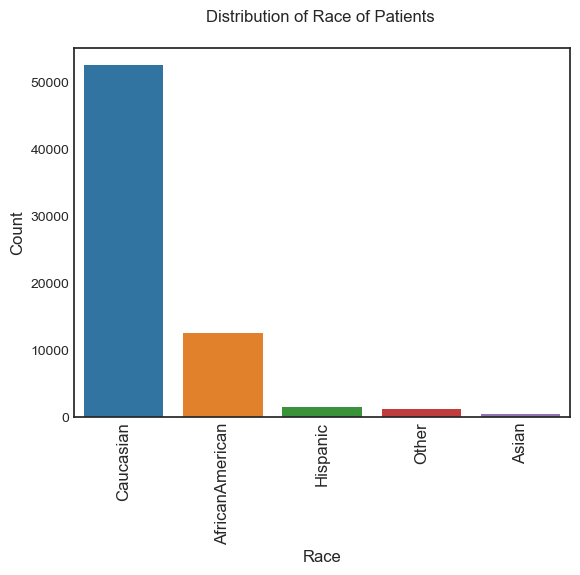

In [15]:
ax = sns.barplot(x=df1['race'].value_counts().index,   y=df1['race'].value_counts())
plt.xlabel('Race', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('Distribution of Race of Patients \n', size = 12)
plt.show()

Dalla distribuzione vediamo come la maggior parte delle persone all'interno del dataset sia di razza caucasica.

Vediamo a sto punto la distribuzione del sesso

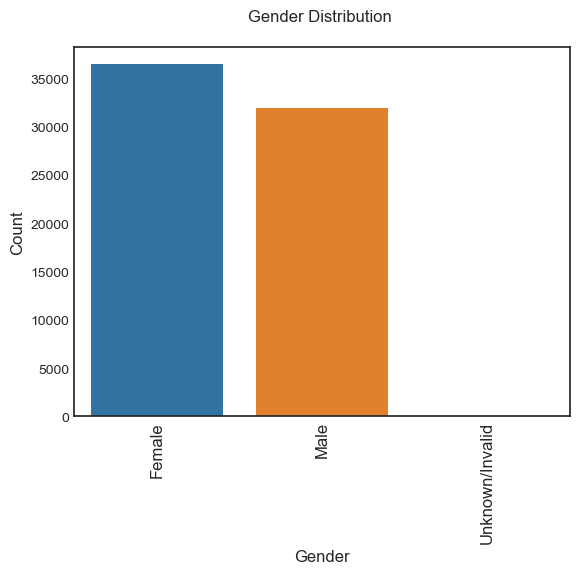

In [16]:
ax = sns.countplot(x='gender',   data= df1)
plt.xlabel('Gender', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('Gender Distribution \n', size = 12)
plt.show()

In [17]:
df1.drop(df1[df1['gender'] == 'Unknown/Invalid'].index, inplace = True)

In [18]:
df1.reset_index(inplace = True, drop = True)

In [19]:
df1.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,Up,No,No,No,No,No,Ch,Yes,0
1,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,No,Yes,1
2,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,Up,No,No,No,No,No,Ch,Yes,1
3,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,Steady,No,No,No,No,No,Ch,Yes,1
4,35754,82637451,Caucasian,Male,[50-60),2,1,2,3,31,...,No,Steady,No,No,No,No,No,No,Yes,0


ENCODING

Tutte le features mediche trasformarle in numeriche, idem insulin, idem change, idem diabetesMed. 

In [20]:
#Cominciamo a fare l'encoding
# Ai fini della mia analisi encounter_id e patient_nbr non sono utili, quindi li elimino
df2=df1.copy()
df2.drop(['encounter_id','patient_nbr'],axis=1,inplace=True)
df2.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[10-20),1,1,7,3,59,0,18,...,No,Up,No,No,No,No,No,Ch,Yes,0
1,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,...,No,No,No,No,No,No,No,No,Yes,1
2,Caucasian,Male,[30-40),1,1,7,2,44,1,16,...,No,Up,No,No,No,No,No,Ch,Yes,1
3,Caucasian,Male,[40-50),1,1,7,1,51,0,8,...,No,Steady,No,No,No,No,No,Ch,Yes,1
4,Caucasian,Male,[50-60),2,1,2,3,31,6,16,...,No,Steady,No,No,No,No,No,No,Yes,0


In [21]:
df2.drop(columns = ['acetohexamide', 'tolbutamide', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
                   'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone',
                   'metformin-pioglitazone'], inplace = True)

In [22]:
df2["race"]=df2["race"].replace(['AfricanAmerican','Hispanic','Other','Asian'],['NonCaucasian','NonCaucasian','NonCaucasian','NonCaucasian'])

In [23]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()

In [24]:
categorical_features =['race','gender','age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin',
       'glyburide-metformin', 'change', 'diabetesMed'] 

for i in categorical_features:
    df2[i] = le.fit_transform(df2[i])

In [25]:
df2.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,glyburide,pioglitazone,rosiglitazone,acarbose,miglitol,insulin,glyburide-metformin,change,diabetesMed,readmitted
0,0,0,1,0,0,6,3,59,0,18,...,1,1,1,0,1,3,1,0,1,0
1,1,0,2,0,0,6,2,11,5,13,...,1,1,1,0,1,1,1,1,1,1
2,0,1,3,0,0,6,2,44,1,16,...,1,1,1,0,1,3,1,0,1,1
3,0,1,4,0,0,6,1,51,0,8,...,1,1,1,0,1,2,1,0,1,1
4,0,1,5,1,0,1,3,31,6,16,...,1,1,1,0,1,2,1,1,1,0


# Fairlearn: Studio del sesso

In [26]:
privileged_sex=np.where(df["gender"]==1)[0]

In [27]:
df3=df2.copy()

In [28]:
df2.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'insulin',
       'glyburide-metformin', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [29]:
feature_cols=['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'insulin',
       'glyburide-metformin', 'change', 'diabetesMed']
X=df3[feature_cols]
print(len(X))
y=df3['readmitted']
print(len(y))


68357
68357


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [31]:
classifier = DecisionTreeClassifier()
classifier=classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)

In [32]:
sex=df["gender"]
df3=df2.copy()
df3=df3.reset_index()
X_test_reset=X_test.reset_index()
X_list=list(X_test_reset["index"])
y_true=df3["readmitted"].loc[X_list]
sex=df3["gender"].loc[X_list]

In [33]:
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)

In [34]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "true positive rate": recall_score,
    "selection rate": selection_rate,
    "count": count,
}

In [35]:
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_true, y_pred=y_pred, sensitive_features=sex
)

array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='gender'>,
        <AxesSubplot:title={'center':'precision'}, xlabel='gender'>,
        <AxesSubplot:title={'center':'false positive rate'}, xlabel='gender'>],
       [<AxesSubplot:title={'center':'false negative rate'}, xlabel='gender'>,
        <AxesSubplot:title={'center':'true positive rate'}, xlabel='gender'>,
        <AxesSubplot:title={'center':'selection rate'}, xlabel='gender'>],
       [<AxesSubplot:title={'center':'count'}, xlabel='gender'>,
        <AxesSubplot:xlabel='gender'>, <AxesSubplot:xlabel='gender'>]],
      dtype=object)

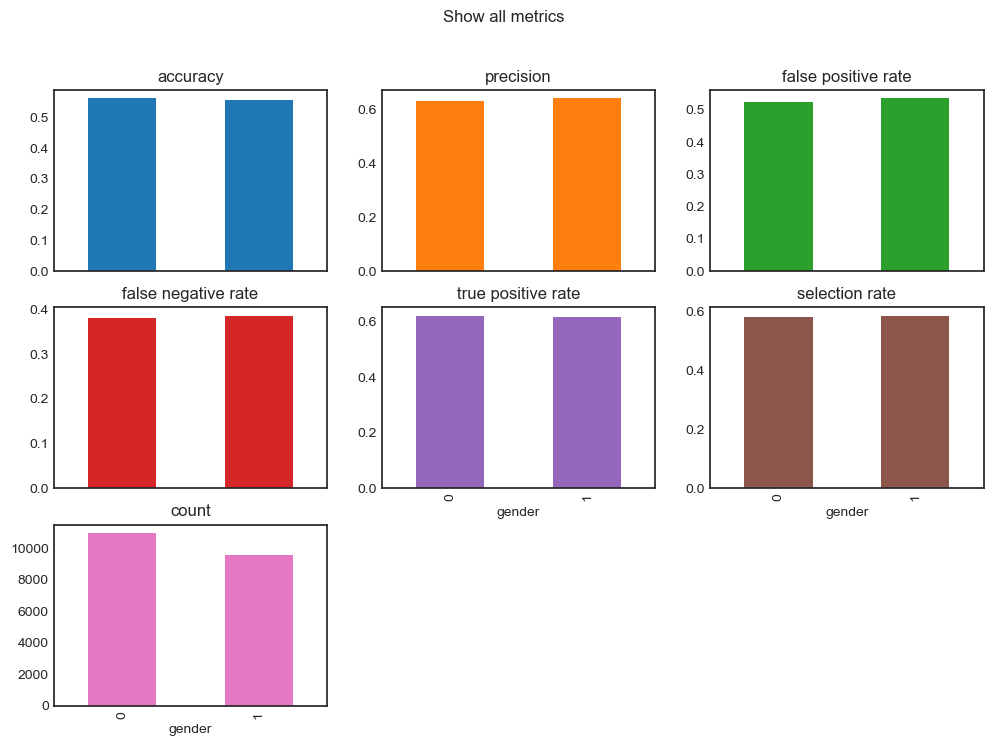

In [36]:
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)


In [54]:
dem_parity=demographic_parity_difference(y_true,y_pred,sensitive_features=sex)
print("demographic parity")
print(demographic_parity_difference(y_true,y_pred,sensitive_features=sex))

demographic parity
0.003216297328208162


In [55]:
x=metric_frame.by_group
print(metric_frame.by_group)

      accuracy  precision  false positive rate  false negative rate  \
race                                                                  
0     0.556766   0.626160             0.528232             0.384062   
1     0.566278   0.666306             0.529176             0.377486   

      true positive rate  selection rate    count  
race                                               
0               0.615938        0.579940  15793.0  
1               0.622514        0.587911   4715.0  


In [56]:
equalize_odds=equalized_odds_difference(y_true, y_pred, sensitive_features=sex)
print("Equalize Odds Difference")
print(equalized_odds_difference(y_true, y_pred, sensitive_features=sex))

Equalize Odds Difference
0.011221857332006535


In [57]:
x["true positive rate"]
equal_opportunity=x["true positive rate"][1]-x["true positive rate"][0]
print("l'equal opportunity vale ",equal_opportunity)

l'equal opportunity vale  0.006576186546625062


# Fairness Race

In [43]:
race=df["race"]
df3=df2.copy()
df3=df3.reset_index()
X_test_reset=X_test.reset_index()
X_list=list(X_test_reset["index"])
y_true=df3["readmitted"].loc[X_list]
race=df3["race"].loc[X_list]

In [44]:
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_true, y_pred=y_pred, sensitive_features=race
)

array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='race'>,
        <AxesSubplot:title={'center':'precision'}, xlabel='race'>,
        <AxesSubplot:title={'center':'false positive rate'}, xlabel='race'>],
       [<AxesSubplot:title={'center':'false negative rate'}, xlabel='race'>,
        <AxesSubplot:title={'center':'true positive rate'}, xlabel='race'>,
        <AxesSubplot:title={'center':'selection rate'}, xlabel='race'>],
       [<AxesSubplot:title={'center':'count'}, xlabel='race'>,
        <AxesSubplot:xlabel='race'>, <AxesSubplot:xlabel='race'>]],
      dtype=object)

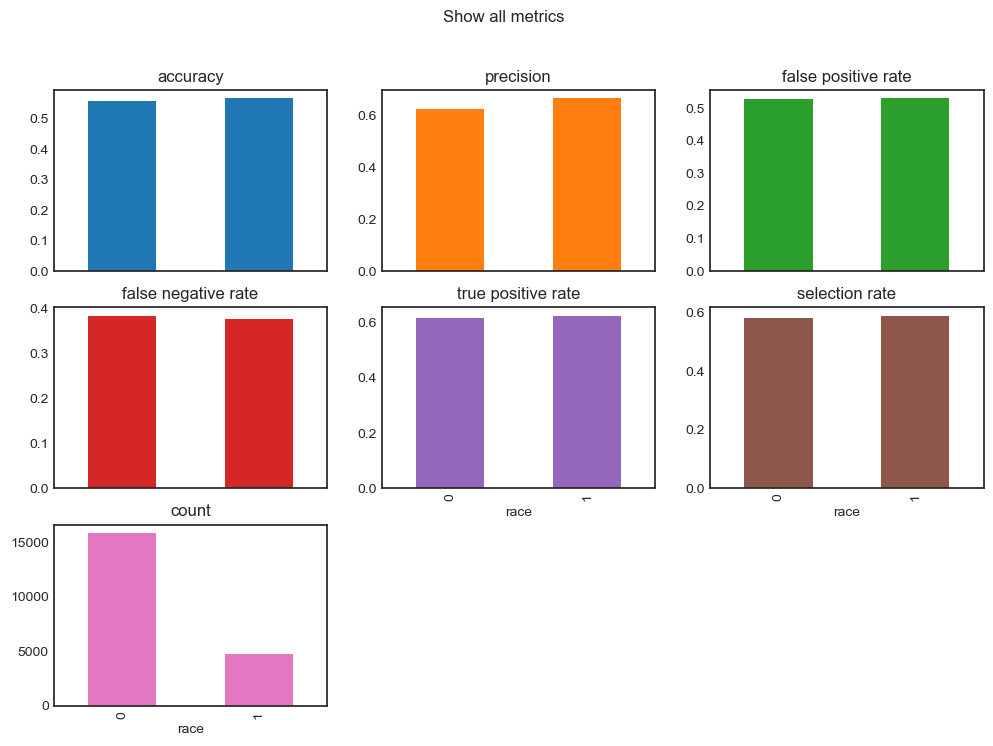

In [45]:
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

In [50]:
dem_parity=demographic_parity_difference(y_true,y_pred,sensitive_features=race)
print("demographic parity")
print(demographic_parity_difference(y_true,y_pred,sensitive_features=race))

demographic parity
0.007970442628011054


In [51]:
x=metric_frame.by_group
print(metric_frame.by_group)

      accuracy  precision  false positive rate  false negative rate  \
race                                                                  
0     0.556766   0.626160             0.528232             0.384062   
1     0.566278   0.666306             0.529176             0.377486   

      true positive rate  selection rate    count  
race                                               
0               0.615938        0.579940  15793.0  
1               0.622514        0.587911   4715.0  


In [52]:
equalize_odds=equalized_odds_difference(y_true, y_pred, sensitive_features=race)
print("Equalize Odds Difference")
print(equalized_odds_difference(y_true, y_pred, sensitive_features=race))

Equalize Odds Difference
0.006576186546625062


In [53]:
x["true positive rate"]
equal_opportunity=x["true positive rate"][1]-x["true positive rate"][0]
print("l'equal opportunity  ",equal_opportunity)

l'equal opportunity   0.006576186546625062
